In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import optuna
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', None)

### Loading and preprocessing

In [2]:
df = pd.read_csv('../data/owd.csv')

In [3]:
df['data'] = df['data'].apply(lambda x: eval(x))
df = df.explode('data')
df.reset_index(drop=True, inplace=True)

In [4]:
df = pd.concat((df, df['data'].apply(pd.Series)), axis=1)
df['dt'] = pd.to_datetime(df['dt'], unit='s')

Removing the dates because each event has accurrate datetime info

In [5]:
df.drop(columns=['Unnamed: 0', 'data', 'createdAt', 'date', 'updatedAt',
                 *[c for c in df.columns if c == 'id' or '_id' in c]], inplace=True)

In [6]:
df['weather'] = df['weather'].apply(lambda x: x[0])

Unpacking all the data from dictionaries within events

In [7]:
dict_col_dfs = []
dict_cols = []

for c in df.columns:
    if type(df[df[c].notnull()].iloc[0][c]) is dict:
        print(c)
        cur = df[c].apply(pd.Series)
        cur.columns = [c + '_' + str(x) for x in cur.columns]
        dict_col_dfs.append(cur)
        dict_cols.append(c)

df = pd.concat([df, *dict_col_dfs], axis=1)
df.drop(columns=dict_cols, inplace=True)

coord
weather
main
wind
clouds
sys
rain
snow


In [8]:
df.head()

base  visibility                  dt  timezone    name  cod  \
0  stations       10000 2022-05-01 01:00:46    -14400  Lontué  200   
1  stations       10000 2022-05-01 01:51:34    -14400  Lontué  200   
2  stations       10000 2022-05-01 03:00:53    -14400  Lontué  200   
3  stations       10000 2022-05-01 04:00:49    -14400  Lontué  200   
4  stations       10000 2022-05-01 04:53:17    -14400  Lontué  200   

          TMS  coord_lon  coord_lat  weather_id weather_main  \
0  1651363200   -71.3337   -35.0264         800        Clear   
1  1651366800   -71.3337   -35.0264         800        Clear   
2  1651370400   -71.3337   -35.0264         800        Clear   
3  1651374000   -71.3337   -35.0264         800        Clear   
4  1651377600   -71.3337   -35.0264         800        Clear   

  weather_description weather_icon  main_temp  main_feels_like  main_temp_min  \
0           clear sky          01n       9.38             8.77           9.38   
1           clear sky          01n      12.30            11.57          12.30   
2           clear sky          01n       8.41             7.55           8.41   
3           clear sky          01n       7.87             6.83           7.87   
4           clear sky          01n       8.30             7.16           8.30   

   main_temp_max  main_pressure  main_humidity  main_sea_level  \
0           9.38         1018.0           78.0          1018.0   
1          12.30         1017.0           76.0             NaN   
2           8.41         1017.0           76.0          1017.0   
3           7.87         1017.0           75.0          1017.0   
4           8.30         1017.0           93.0             NaN   

   main_grnd_level  wind_speed  wind_deg  wind_gust  clouds_all sys_country  \
0            995.0        1.67     187.0       1.74           0          CL   
1              NaN        2.06     210.0        NaN           0          CL   
2            995.0        1.77     186.0       1.81           0          CL   
3            994.0        1.87     188.0       1.89           0          CL   
4              NaN        2.06     170.0        NaN           0          CL   

   sys_sunrise  sys_sunset  sys_type  sys_id  rain_0  rain_1h  snow_0  snow_1h  
0   1651317655  1651356238       NaN     NaN     NaN      NaN     NaN      NaN  
1   1651317655  1651356238       1.0  8497.0     NaN      NaN     NaN      NaN  
2   1651317655  1651356238       NaN     NaN     NaN      NaN     NaN      NaN  
3   1651404104  1651442576       NaN     NaN     NaN      NaN     NaN      NaN  
4   1651404104  1651442576       1.0  8497.0     NaN      NaN     NaN      NaN

Removing columns with too many NaNs and just a single value for the whole column

In [9]:
df.drop(columns=[c for c in df.columns if df[c].isna().sum() > 3600], inplace=True)
df.drop(columns=[c for c in df.columns if df[c].nunique() == 1], inplace=True)

These columns are just useless, and don't affect anything to do with weather

In [10]:
df.drop(columns=['TMS', 'timezone', 'weather_icon', 'sys_type', 'sys_id'], inplace=True)

In [12]:
df.drop(columns=['weather_main', 'weather_description'], inplace=True)

### Dataset creation

Changing from task 2, we will see later that day and hour features are actually important, so I decided to keep them in

In [13]:
df['day'] = df['dt'].dt.dayofyear
df['hour'] = df['dt'].dt.hour
df['day_length'] = df['sys_sunset'] = df['sys_sunrise']
X = df.drop(columns=['dt', 'weather_id', 'sys_sunrise', 'sys_sunset'], axis=1)

y = df['weather_id']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

### Training

Here, I'm using all the same techniques as in task 2. The motivation for using both LightGBM and Optuna remains the same. I also tried using logistic regression but as you will see later, comparatively it performs very poorly

In [14]:
def objective(trial):
    params = {
        'objective': 'multiclass',
        'n_estimators': 500,
        'metric': 'multi_logloss',
        'verbosity': -1,
        'bagging_freq': 1,
        'max_depth': trial.suggest_int('max_depth', 2, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 128),
        'subsample': trial.suggest_float('subsample', 0.05, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1.0),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 50),
        'feature_pre_filter': False,
        'n_jobs': 4
    }

    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train, callbacks=[
                         lgb.early_stopping(stopping_rounds=100, min_delta=0.0005, verbose=False)
                     ], eval_set=[(X_val, y_val)], eval_metric='multi_logloss')
    
    predictions = model.predict(X_val)
    
    acc = accuracy_score(y_val, predictions)
    return acc

In [15]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-05-27 08:14:58,502] A new study created in memory with name: no-name-2c2a815a-4082-4e71-971f-d54fe7981b22
[I 2024-05-27 08:15:03,559] Trial 0 finished with value: 0.9870466321243523 and parameters: {'max_depth': 7, 'learning_rate': 0.006368918475924361, 'num_leaves': 17, 'subsample': 0.5848679663731182, 'colsample_bytree': 0.5348322531066705, 'min_data_in_leaf': 39}. Best is trial 0 with value: 0.9870466321243523.
[I 2024-05-27 08:15:06,742] Trial 1 finished with value: 0.9870466321243523 and parameters: {'max_depth': 8, 'learning_rate': 0.026533750098230703, 'num_leaves': 49, 'subsample': 0.7971613690146442, 'colsample_bytree': 0.5634268654054464, 'min_data_in_leaf': 47}. Best is trial 0 with value: 0.9870466321243523.
[I 2024-05-27 08:15:09,329] Trial 2 finished with value: 0.9287564766839378 and parameters: {'max_depth': 3, 'learning_rate': 0.0013501204789566489, 'num_leaves': 31, 'subsample': 0.951996982036623, 'colsample_bytree': 0.39047219064106176, 'min_data_in_leaf': 4}

Using the best parameters to train the final model

In [16]:
model = lgb.LGBMClassifier(**{'objective': 'multiclass', 'n_estimators': 500, 'metric': 'multi_logloss', 'verbosity': -1,
                            'bagging_freq': 1, 'feature_pre_filter': False, **study.best_params})
model.fit(X_train, y_train, callbacks=[
                         lgb.early_stopping(stopping_rounds=100, min_delta=0.0005, verbose=False)
                     ], eval_set=[(X_val, y_val)], eval_metric='multi_logloss')

LGBMClassifier(bagging_freq=1, colsample_bytree=0.8682559558078267,
               feature_pre_filter=False, learning_rate=0.03809973886716816,
               max_depth=11, metric='multi_logloss', min_data_in_leaf=23,
               n_estimators=500, num_leaves=100, objective='multiclass',
               subsample=0.9669245717574403, verbosity=-1)

### Model evaluation

In [17]:
predictions = model.predict(X_test)

In [18]:
res = pd.DataFrame(y_test)

In [19]:
accuracy_score(y_test, predictions)

0.9848942598187311

All the logic pretaining to feature importances from task 2 also applies here. Although in this case, the importance of the top feature is not as much higher than the rest

C:\Users\amost\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\plotting.py:152: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xlim)


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

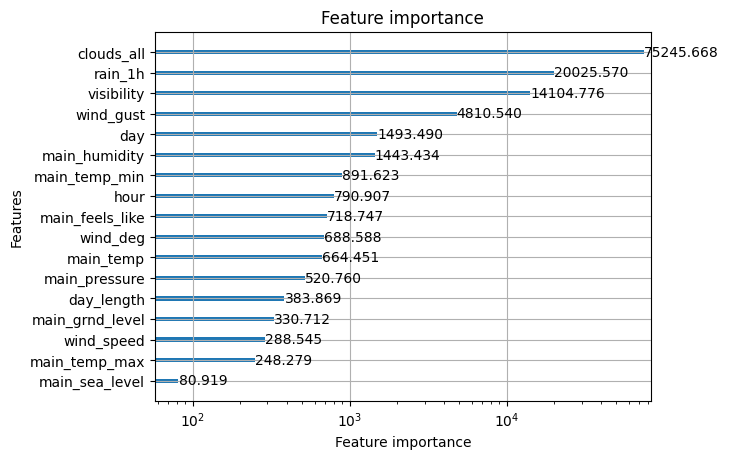

In [20]:
lgb.plot_importance(model, importance_type='gain', log=True)

### Saving the model

In [21]:
model.booster_.save_model('lgbm.txt')

### Trying logistic regression

Similarly to task 2, I tried regression as an alternative to boosting. Sklearn's logistic regression supports multinomial classification but the difference between regression and boosting is even more pronounced here

In [22]:
model = LogisticRegression(multi_class='multinomial', max_iter=10000)

In [23]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3)

In [24]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [25]:
model.fit(X_train, y_train)

C:\Users\amost\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [26]:
predictions = model.predict(X_val)

In [27]:
res = pd.DataFrame(y_val)

In [28]:
accuracy_score(y_val, predictions)

0.3925657298277425